In [29]:
# CREATE THE DATASET, 03/31/2025, random seed 44

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Set random seed for reproducibility
np.random.seed(44)

# Define battery types and their typical compositions
battery_types = {
    'EV_NMC811': {'Li': [8, 10], 'Co': [2, 3], 'Ni': [14, 17], 'Mn': [2, 3], 'energy_density': [250, 300]},
    'EV_NMC622': {'Li': [7, 9], 'Co': [5, 7], 'Ni': [10, 12], 'Mn': [4, 6], 'energy_density': [200, 250]},
    'EV_LFP': {'Li': [10, 12], 'Co': [0, 0.5], 'Ni': [0, 0.5], 'Mn': [0, 0.5], 'energy_density': [160, 180]},
    'Consumer_NMC': {'Li': [6, 8], 'Co': [6, 8], 'Ni': [6, 8], 'Mn': [6, 8], 'energy_density': [180, 220]},
    'Consumer_LCO': {'Li': [5, 7], 'Co': [12, 15], 'Ni': [0, 0.5], 'Mn': [0, 0.5], 'energy_density': [150, 200]},
    'Industrial_LMO': {'Li': [6, 8], 'Co': [0, 1], 'Ni': [0, 1], 'Mn': [10, 13], 'energy_density': [120, 150]}
}

# Generate dataset
num_samples = 500
data = []

for i in range(num_samples):
    # Randomly select battery type
    b_type = np.random.choice(list(battery_types.keys()))
    specs = battery_types[b_type]
    
    # Generate battery age and usage (correlated)
    age = np.random.uniform(0.5, 10)  # 6 months to 10 years
    max_cycles = 3000 - 200 * age  # Newer batteries have more potential cycles
    cycles_used = np.random.uniform(0, min(max_cycles, 2500))
    
    # Calculate degradation factor (affects recovery rates)
    degradation = (age * 0.05) + (cycles_used / 10000)
    degradation = min(0.7, degradation)  # Cap at 70% degradation
    
    # Generate base composition with random variation within type ranges
    li_content = np.random.uniform(specs['Li'][0], specs['Li'][1])
    co_content = np.random.uniform(specs['Co'][0], specs['Co'][1])
    ni_content = np.random.uniform(specs['Ni'][0], specs['Ni'][1])
    mn_content = np.random.uniform(specs['Mn'][0], specs['Mn'][1])
    energy_density = np.random.uniform(specs['energy_density'][0], specs['energy_density'][1])
    
    # Generate recycling process parameters
    # Temperature affects recovery but has energy cost tradeoff
    recycle_temp = np.random.uniform(40, 90)  # Celsius
    
    # Process time also affects recovery efficiency
    recycle_time = np.random.uniform(2, 8)  # Hours
    
    # Recovery rates depend on composition, degradation, and process parameters
    # Higher temperatures and longer times generally improve recovery
    temp_factor = (recycle_temp - 40) / 50  # Normalize to 0-1
    time_factor = (recycle_time - 2) / 6    # Normalize to 0-1
    
    # Base recovery rates
    li_recovery_base = 0.75 + (0.2 * temp_factor) + (0.1 * time_factor)
    co_recovery_base = 0.85 + (0.12 * temp_factor) + (0.08 * time_factor)
    ni_recovery_base = 0.82 + (0.15 * temp_factor) + (0.08 * time_factor)
    mn_recovery_base = 0.78 + (0.18 * temp_factor) + (0.09 * time_factor)
    
    # Adjust for degradation
    li_recovery = li_recovery_base * (1 - degradation * 0.5) * np.random.uniform(0.95, 1.05)
    co_recovery = co_recovery_base * (1 - degradation * 0.3) * np.random.uniform(0.95, 1.05)
    ni_recovery = ni_recovery_base * (1 - degradation * 0.4) * np.random.uniform(0.95, 1.05)
    mn_recovery = mn_recovery_base * (1 - degradation * 0.3) * np.random.uniform(0.95, 1.05)
    
    # Cap recovery rates at 98%
    li_recovery = min(0.98, li_recovery)
    co_recovery = min(0.98, co_recovery)
    ni_recovery = min(0.98, ni_recovery)
    mn_recovery = min(0.98, mn_recovery)
    
    # Energy consumption (kWh) increases with temperature and time
    energy_consumed = 15 + (recycle_temp * 0.5) + (recycle_time * 3) + np.random.uniform(-5, 5)
    
    # Process cost (€) depends on energy and time
    labor_cost = recycle_time * 25  # €/hour labor cost
    energy_cost = energy_consumed * 0.25  # €/kWh
    chemical_cost = 15 + (5 * recycle_time)  # Base cost plus per hour
    process_cost = labor_cost + energy_cost + chemical_cost + np.random.uniform(-10, 10)
    
    # Material value recovered (€)
    li_value = li_content * li_recovery * 35  # €/kg lithium value
    co_value = co_content * co_recovery * 45  # €/kg cobalt value
    ni_value = ni_content * ni_recovery * 20  # €/kg nickel value
    mn_value = mn_content * mn_recovery * 3   # €/kg manganese value
    total_value = li_value + co_value + ni_value + mn_value
    
    # Net profit
    profit_margin = (total_value - process_cost) / process_cost
    
    data.append({
        'battery_id': i + 1000,
        'battery_type': b_type,
        'lithium_content': li_content,
        'cobalt_content': co_content,
        'nickel_content': ni_content,
        'manganese_content': mn_content,
        'age_years': age,
        'charge_cycles': cycles_used,
        'energy_density': energy_density,
        'recycling_temp': recycle_temp,
        'recycling_time': recycle_time,
        'lithium_recovery_rate': li_recovery,
        'cobalt_recovery_rate': co_recovery,
        'nickel_recovery_rate': ni_recovery,
        'manganese_recovery_rate': mn_recovery,
        'energy_consumed': energy_consumed,
        'process_cost': process_cost,
        'materials_value': total_value,
        'profit_margin': profit_margin
    })

# Create DataFrame
df = pd.DataFrame(data)


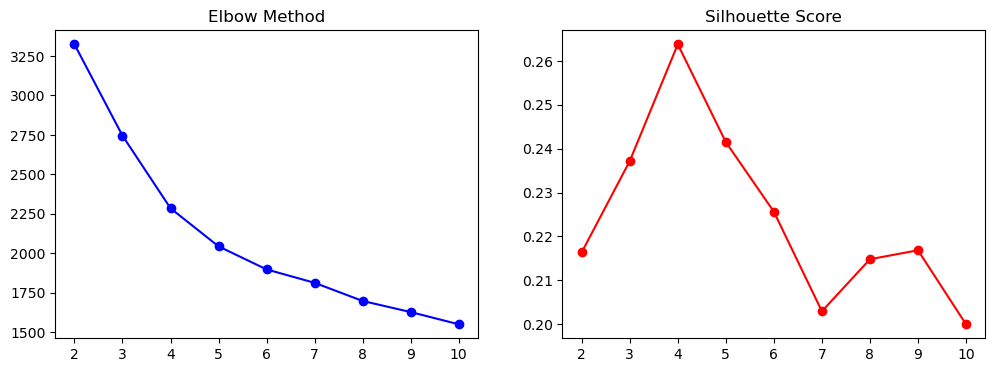

In [30]:
# Determine the number of clusters (K)

features = ['lithium_content', 'cobalt_content', 'nickel_content', 'manganese_content',
            'age_years', 'charge_cycles', 'recycling_temp', 'recycling_time']

# Scale data
X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow + Silhouette analysis
k_values = range(2, 11)  # Start at k=2 (silhouette requires >=2 clusters)
wcss = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(k_values, wcss, marker='o', color='b')
ax1.set_title('Elbow Method')
ax2.plot(k_values, silhouette_scores, marker='o', color='r')
ax2.set_title('Silhouette Score')
plt.show()

For k = 3:
Inertia (WCSS): 2745.4671

Silhouette Score: 0.2372


Cluster Centers (Original Units):
   lithium_content  cobalt_content  nickel_content  manganese_content  \
0             6.08           13.66            0.23               0.26   
1             7.72            4.03            8.19               6.70   
2            10.97            0.22            0.22               0.24   

   age_years  charge_cycles  recycling_temp  recycling_time  
0       5.56         999.11           64.82            5.00  
1       5.35         925.55           65.05            4.94  
2       5.21         972.46           66.54            5.43  


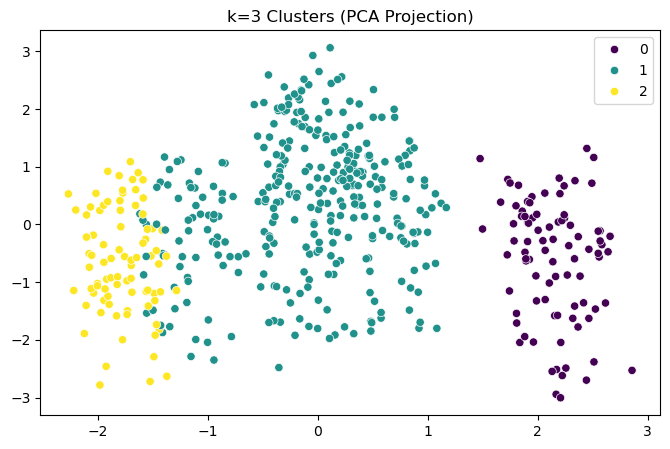

For k = 4:
Inertia (WCSS): 2285.8407

Silhouette Score: 0.2638


Cluster Centers (Original Units):
   lithium_content  cobalt_content  nickel_content  manganese_content  \
0             7.98            5.29           10.94               4.94   
1             6.08           13.66            0.23               0.26   
2             7.00            0.50            0.51              11.63   
3            10.97            0.22            0.22               0.24   

   age_years  charge_cycles  recycling_temp  recycling_time  
0       5.28         969.28           65.14            4.95  
1       5.56         999.11           64.82            5.00  
2       5.54         803.01           64.80            4.90  
3       5.21         972.46           66.54            5.43  


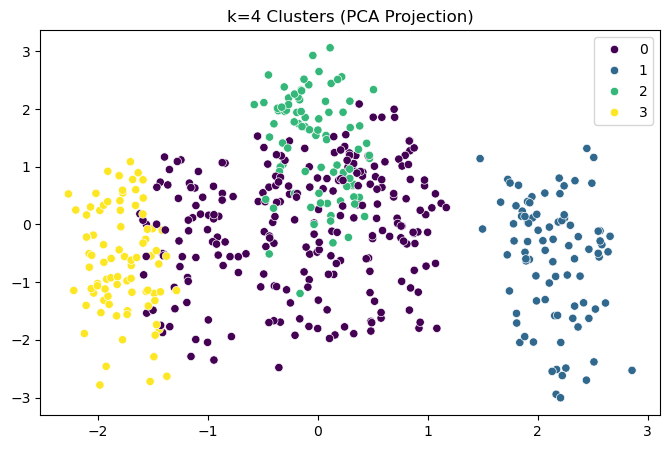

For k = 5:
Inertia (WCSS): 2044.6708

Silhouette Score: 0.2415


Cluster Centers (Original Units):
   lithium_content  cobalt_content  nickel_content  manganese_content  \
0             7.85            5.60           10.33               5.18   
1             8.07            5.05           11.28               4.80   
2             6.99            0.50            0.51              11.65   
3             6.08           13.66            0.23               0.26   
4            10.97            0.22            0.22               0.24   

   age_years  charge_cycles  recycling_temp  recycling_time  
0       3.01        1466.29           63.53            5.41  
1       6.82         633.99           66.22            4.62  
2       5.60         786.28           64.84            4.93  
3       5.56         999.11           64.82            5.00  
4       5.21         972.46           66.54            5.43  


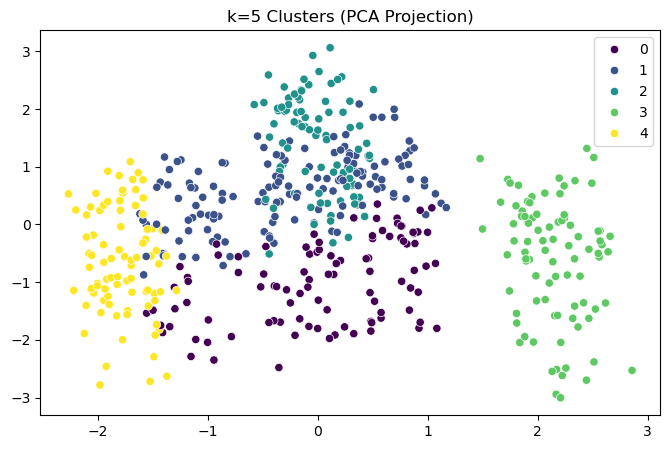

In [31]:
# Cluster Analysis based on this elbow graph

cluster_values = [3,4,5]
kmeans_models = {}

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for k in cluster_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)  # Store labels in a variable
    df[f'cluster_k{k}'] = labels  # Also store in DataFrame
    kmeans_models[k] = kmeans

    #Metrics
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(X_scaled, labels)

    # Print Metrics
    print(f"For k = {k}:")
    print(f"Inertia (WCSS): {kmeans.inertia_:.4f}\n")
    print(f"Silhouette Score: {silhouette_avg:.4f}\n")  

    # Inverse-transform centers
    centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
    df_centers = pd.DataFrame(centers_original, columns=features)
    print("\nCluster Centers (Original Units):")
    print(df_centers.round(2))

    # Visualize
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="viridis")
    plt.title(f'k={k} Clusters (PCA Projection)')
    plt.show()

    #plt.figure(figsize=(8, 5))
    #labels = kmeans_models[k].labels_
    #ns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="viridis", alpha=0.7)
    #plt.title(f'Cluster Assignments (k={k})')
    #plt.show()
    


Profiling for k=3


'\nCluster Profiles (k=3):'

lithium_content       cobalt_content       nickel_content        \
                      mean   std           mean   std           mean   std   
cluster_k3                                                                   
0                     6.08  0.55          13.66  0.92           0.23  0.15   
1                     7.72  1.03           4.03  2.70           8.19  5.50   
2                    10.97  0.56           0.22  0.16           0.22  0.14   

           manganese_content       age_years       charge_cycles          \
                        mean   std      mean   std          mean     std   
cluster_k3                                                                 
0                       0.26  0.15      5.56  2.81        999.11  657.99   
1                       6.70  3.41      5.35  2.72        925.55  591.25   
2                       0.24  0.14      5.21  2.48        972.46  619.62   

           recycling_temp        recycling_time       size  
                     mean    std           mean   std       
cluster_k3                                                  
0                   64.82  14.72           5.00  1.72   88  
1                   65.05  14.28           4.94  1.77  327  
2                   66.54  13.25           5.43  1.72   85

'\nBattery Type Distribution (k=3):'

cluster_k3       0   1   2
battery_type              
Consumer_LCO    88   0   0
Consumer_NMC     0  84   0
EV_LFP           0   0  85
EV_NMC622        0  87   0
EV_NMC811        0  70   0
Industrial_LMO   0  86   0

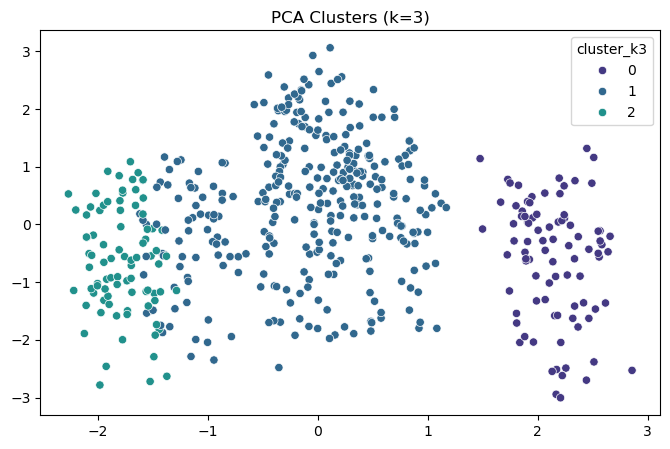

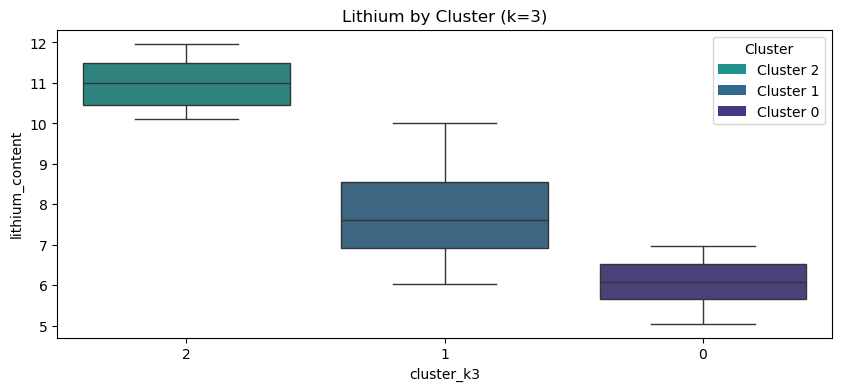


Profiling for k=4


'\nCluster Profiles (k=4):'

lithium_content       cobalt_content       nickel_content        \
                      mean   std           mean   std           mean   std   
cluster_k4                                                                   
0                     7.98  1.03           5.29  1.94          10.94  3.52   
1                     6.08  0.55          13.66  0.92           0.23  0.15   
2                     7.00  0.61           0.50  0.31           0.51  0.29   
3                    10.97  0.56           0.22  0.16           0.22  0.14   

           manganese_content       age_years       charge_cycles          \
                        mean   std      mean   std          mean     std   
cluster_k4                                                                 
0                       4.94  1.91      5.28  2.70        969.28  609.68   
1                       0.26  0.15      5.56  2.81        999.11  657.99   
2                      11.63  0.87      5.54  2.80        803.01  520.18   
3                       0.24  0.14      5.21  2.48        972.46  619.62   

           recycling_temp        recycling_time       size  
                     mean    std           mean   std       
cluster_k4                                                  
0                   65.14  13.92           4.95  1.81  241  
1                   64.82  14.72           5.00  1.72   88  
2                   64.80  15.33           4.90  1.69   86  
3                   66.54  13.25           5.43  1.72   85

'\nBattery Type Distribution (k=4):'

cluster_k4       0   1   2   3
battery_type                  
Consumer_LCO     0  88   0   0
Consumer_NMC    84   0   0   0
EV_LFP           0   0   0  85
EV_NMC622       87   0   0   0
EV_NMC811       70   0   0   0
Industrial_LMO   0   0  86   0

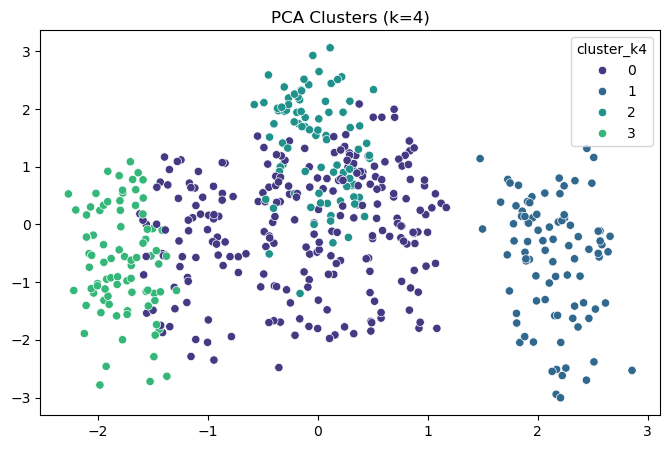

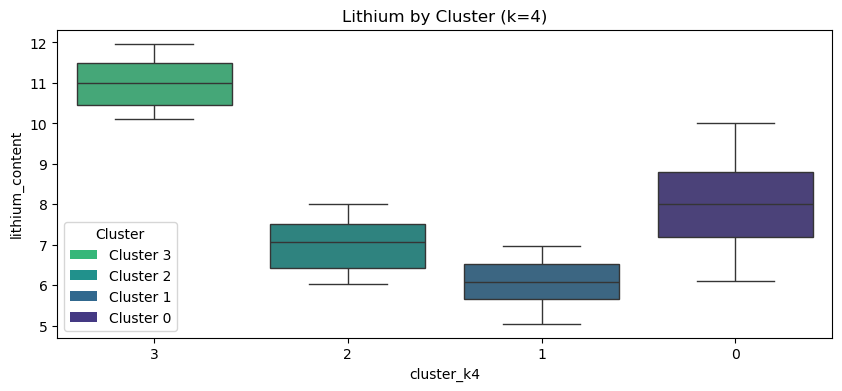


Profiling for k=5


'\nCluster Profiles (k=5):'

lithium_content       cobalt_content       nickel_content        \
                      mean   std           mean   std           mean   std   
cluster_k5                                                                   
0                     7.85  1.04           5.60  1.93          10.33  3.47   
1                     8.07  1.01           5.05  1.95          11.28  3.62   
2                     6.99  0.61           0.50  0.31           0.51  0.29   
3                     6.08  0.55          13.66  0.92           0.23  0.15   
4                    10.97  0.56           0.22  0.16           0.22  0.14   

           manganese_content       age_years       charge_cycles          \
                        mean   std      mean   std          mean     std   
cluster_k5                                                                 
0                       5.18  1.86      3.01  1.56       1466.29  549.19   
1                       4.80  1.98      6.82  2.18        633.99  381.81   
2                      11.65  0.86      5.60  2.77        786.28  499.43   
3                       0.26  0.15      5.56  2.81        999.11  657.99   
4                       0.24  0.14      5.21  2.48        972.46  619.62   

           recycling_temp        recycling_time       size  
                     mean    std           mean   std       
cluster_k5                                                  
0                   63.53  13.60           5.41  1.86   99  
1                   66.22  14.03           4.62  1.71  143  
2                   64.84  15.42           4.93  1.68   85  
3                   64.82  14.72           5.00  1.72   88  
4                   66.54  13.25           5.43  1.72   85

'\nBattery Type Distribution (k=5):'

cluster_k5       0   1   2   3   4
battery_type                      
Consumer_LCO     0   0   0  88   0
Consumer_NMC    39  45   0   0   0
EV_LFP           0   0   0   0  85
EV_NMC622       37  50   0   0   0
EV_NMC811       22  48   0   0   0
Industrial_LMO   1   0  85   0   0

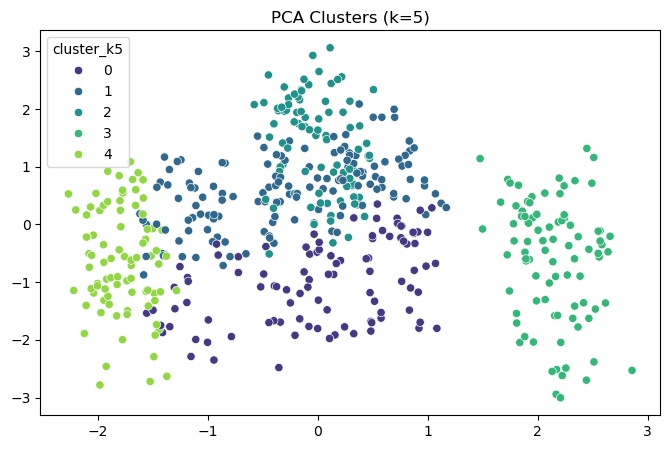

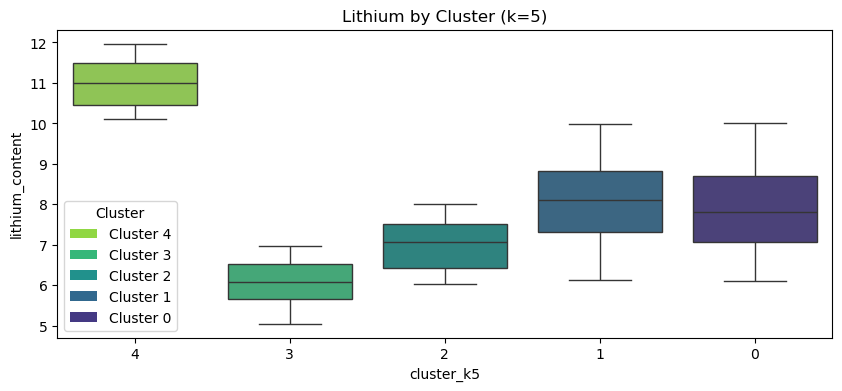

In [32]:
# Analyze clusters
for k in cluster_values:
    print(f"\n{'='*50}\nProfiling for k={k}\n{'='*50}")
    
    clusters = df[f'cluster_k{k}']
    hue_order = sorted(clusters.unique())
    palette = sns.color_palette("viridis", n_colors=5)  
   
    
    # Assign clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    labels = kmeans.fit_predict(X_scaled)
    df[f'cluster_k{k}'] = kmeans.labels_  # Store labels in DataFrame
    
    # --- Cluster Statistics ---
    # Mean + Std of features per cluster
    profile = df.groupby(f'cluster_k{k}')[features].agg(['mean', 'std']).round(2)
    # Add cluster sizes
    profile['size'] = df[f'cluster_k{k}'].value_counts().sort_index()
    display(f"\nCluster Profiles (k={k}):")
    display(profile)
    
    # --- Battery Type Distribution ---
    if 'battery_type' in df.columns:
        display(f"\nBattery Type Distribution (k={k}):")
        display(pd.crosstab(df['battery_type'], df[f'cluster_k{k}']))
    
    # --- Visualizations ---
    # PCA Plot
    plt.figure(figsize=(8, 5))
    scatter = sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], 
        hue=clusters, palette=palette[:k], 
        hue_order=hue_order, legend='full'
    )
    plt.title(f'PCA Clusters (k={k})')
    plt.show()
    
    # Box Plot (fixed)
    custom_order = sorted(df[f'cluster_k{k}'].unique(), reverse=True)  
    
    plt.figure(figsize=(10, 4))
    box = sns.boxplot(
        data=df, x=f'cluster_k{k}', y='lithium_content', 
        hue=clusters,  # Explicitly use hue
        palette=palette[:k], 
        order=custom_order,
        hue_order=hue_order,
        legend=False,  
        dodge=False   
    )
    plt.title(f'Lithium by Cluster (k={k})')
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=palette[i], 
                       label=f'Cluster {i}') for i in custom_order]
    plt.legend(handles=legend_elements, title='Cluster')
    
    plt.show()

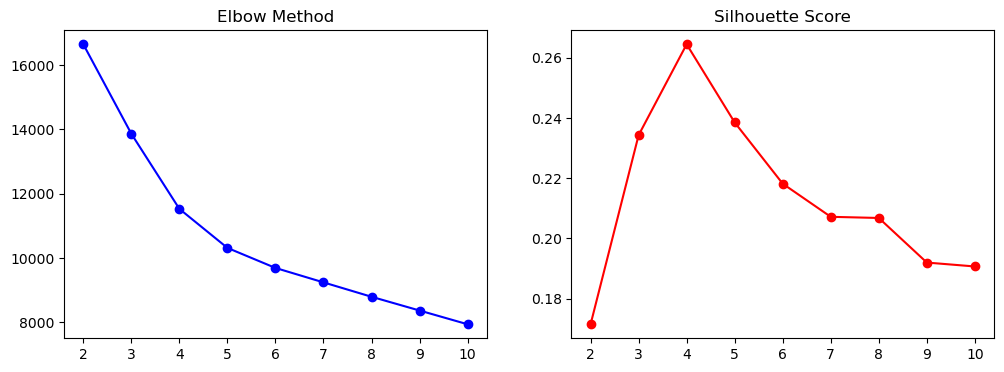

In [33]:
# Same Process, larger dataset, Random seed 46

np.random.seed(46)

# Define battery types and their typical compositions
battery_types = {
    'EV_NMC811': {'Li': [8, 10], 'Co': [2, 3], 'Ni': [14, 17], 'Mn': [2, 3], 'energy_density': [250, 300]},
    'EV_NMC622': {'Li': [7, 9], 'Co': [5, 7], 'Ni': [10, 12], 'Mn': [4, 6], 'energy_density': [200, 250]},
    'EV_LFP': {'Li': [10, 12], 'Co': [0, 0.5], 'Ni': [0, 0.5], 'Mn': [0, 0.5], 'energy_density': [160, 180]},
    'Consumer_NMC': {'Li': [6, 8], 'Co': [6, 8], 'Ni': [6, 8], 'Mn': [6, 8], 'energy_density': [180, 220]},
    'Consumer_LCO': {'Li': [5, 7], 'Co': [12, 15], 'Ni': [0, 0.5], 'Mn': [0, 0.5], 'energy_density': [150, 200]},
    'Industrial_LMO': {'Li': [6, 8], 'Co': [0, 1], 'Ni': [0, 1], 'Mn': [10, 13], 'energy_density': [120, 150]}
}

# Generate dataset
num_samples = 2500
data = []

for i in range(num_samples):
    # Randomly select battery type
    b_type = np.random.choice(list(battery_types.keys()))
    specs = battery_types[b_type]
    
    # Generate battery age and usage (correlated)
    age = np.random.uniform(0.5, 10)  # 6 months to 10 years
    max_cycles = 3000 - 200 * age  # Newer batteries have more potential cycles
    cycles_used = np.random.uniform(0, min(max_cycles, 2500))
    
    # Calculate degradation factor (affects recovery rates)
    degradation = (age * 0.05) + (cycles_used / 10000)
    degradation = min(0.7, degradation)  # Cap at 70% degradation
    
    # Generate base composition with random variation within type ranges
    li_content = np.random.uniform(specs['Li'][0], specs['Li'][1])
    co_content = np.random.uniform(specs['Co'][0], specs['Co'][1])
    ni_content = np.random.uniform(specs['Ni'][0], specs['Ni'][1])
    mn_content = np.random.uniform(specs['Mn'][0], specs['Mn'][1])
    energy_density = np.random.uniform(specs['energy_density'][0], specs['energy_density'][1])
    
    # Generate recycling process parameters
    # Temperature affects recovery but has energy cost tradeoff
    recycle_temp = np.random.uniform(40, 90)  # Celsius
    
    # Process time also affects recovery efficiency
    recycle_time = np.random.uniform(2, 8)  # Hours
    
    # Recovery rates depend on composition, degradation, and process parameters
    # Higher temperatures and longer times generally improve recovery
    temp_factor = (recycle_temp - 40) / 50  # Normalize to 0-1
    time_factor = (recycle_time - 2) / 6    # Normalize to 0-1
    
    # Base recovery rates
    li_recovery_base = 0.75 + (0.2 * temp_factor) + (0.1 * time_factor)
    co_recovery_base = 0.85 + (0.12 * temp_factor) + (0.08 * time_factor)
    ni_recovery_base = 0.82 + (0.15 * temp_factor) + (0.08 * time_factor)
    mn_recovery_base = 0.78 + (0.18 * temp_factor) + (0.09 * time_factor)
    
    # Adjust for degradation
    li_recovery = li_recovery_base * (1 - degradation * 0.5) * np.random.uniform(0.95, 1.05)
    co_recovery = co_recovery_base * (1 - degradation * 0.3) * np.random.uniform(0.95, 1.05)
    ni_recovery = ni_recovery_base * (1 - degradation * 0.4) * np.random.uniform(0.95, 1.05)
    mn_recovery = mn_recovery_base * (1 - degradation * 0.3) * np.random.uniform(0.95, 1.05)
    
    # Cap recovery rates at 98%
    li_recovery = min(0.98, li_recovery)
    co_recovery = min(0.98, co_recovery)
    ni_recovery = min(0.98, ni_recovery)
    mn_recovery = min(0.98, mn_recovery)
    
    # Energy consumption (kWh) increases with temperature and time
    energy_consumed = 15 + (recycle_temp * 0.5) + (recycle_time * 3) + np.random.uniform(-5, 5)
    
    # Process cost (€) depends on energy and time
    labor_cost = recycle_time * 25  # €/hour labor cost
    energy_cost = energy_consumed * 0.25  # €/kWh
    chemical_cost = 15 + (5 * recycle_time)  # Base cost plus per hour
    process_cost = labor_cost + energy_cost + chemical_cost + np.random.uniform(-10, 10)
    
    # Material value recovered (€)
    li_value = li_content * li_recovery * 35  # €/kg lithium value
    co_value = co_content * co_recovery * 45  # €/kg cobalt value
    ni_value = ni_content * ni_recovery * 20  # €/kg nickel value
    mn_value = mn_content * mn_recovery * 3   # €/kg manganese value
    total_value = li_value + co_value + ni_value + mn_value
    
    # Net profit
    profit_margin = (total_value - process_cost) / process_cost
    
    data.append({
        'battery_id': i + 1000,
        'battery_type': b_type,
        'lithium_content': li_content,
        'cobalt_content': co_content,
        'nickel_content': ni_content,
        'manganese_content': mn_content,
        'age_years': age,
        'charge_cycles': cycles_used,
        'energy_density': energy_density,
        'recycling_temp': recycle_temp,
        'recycling_time': recycle_time,
        'lithium_recovery_rate': li_recovery,
        'cobalt_recovery_rate': co_recovery,
        'nickel_recovery_rate': ni_recovery,
        'manganese_recovery_rate': mn_recovery,
        'energy_consumed': energy_consumed,
        'process_cost': process_cost,
        'materials_value': total_value,
        'profit_margin': profit_margin
    })

# Create DataFrame
df = pd.DataFrame(data)

# Determine the number of clusters (K)

features = ['lithium_content', 'cobalt_content', 'nickel_content', 'manganese_content',
            'age_years', 'charge_cycles', 'recycling_temp', 'recycling_time']

# Scale data
X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow + Silhouette analysis
k_values = range(2, 11)  
wcss = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(k_values, wcss, marker='o', color='b')
ax1.set_title('Elbow Method')
ax2.plot(k_values, silhouette_scores, marker='o', color='r')
ax2.set_title('Silhouette Score')
plt.show()


For k = 3:
Inertia (WCSS): 13866.4208

Silhouette Score: 0.2343


Cluster Centers (Original Units):
   lithium_content  cobalt_content  nickel_content  manganese_content  \
0            11.02            0.24            0.26               0.25   
1             6.01           13.52            0.25               0.24   
2             7.70            3.91            8.27               6.66   

   age_years  charge_cycles  recycling_temp  recycling_time  
0       5.19         948.97           65.39            5.05  
1       5.29         943.69           65.36            4.99  
2       5.26         947.02           65.18            4.96  


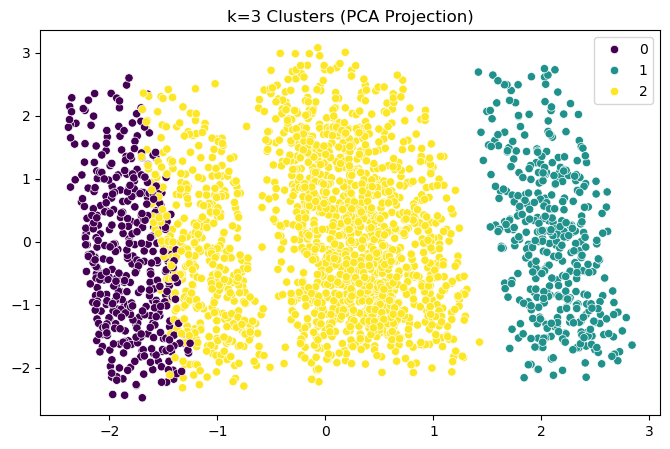

For k = 4:
Inertia (WCSS): 11528.3481

Silhouette Score: 0.2645


Cluster Centers (Original Units):
   lithium_content  cobalt_content  nickel_content  manganese_content  \
0             6.01           13.52            0.25               0.24   
1            11.02            0.24            0.26               0.25   
2             7.97            5.17           11.14               4.86   
3             6.98            0.51            0.53              11.54   

   age_years  charge_cycles  recycling_temp  recycling_time  
0       5.29         943.69           65.36            4.99  
1       5.19         948.97           65.39            5.05  
2       5.30         936.49           65.22            4.93  
3       5.15         975.49           65.08            5.07  


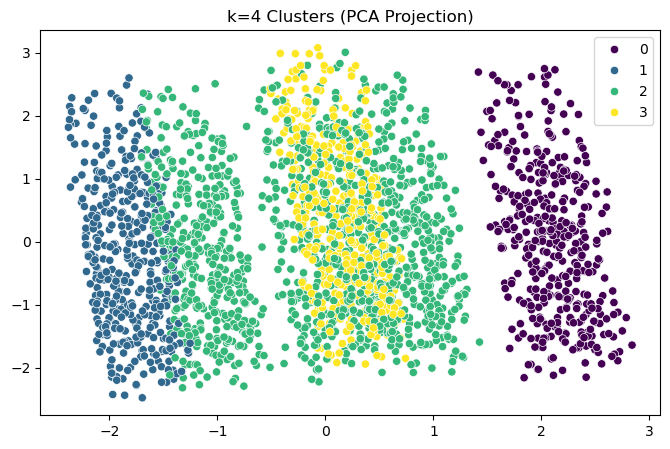

For k = 5:
Inertia (WCSS): 10313.5537

Silhouette Score: 0.2385


Cluster Centers (Original Units):
   lithium_content  cobalt_content  nickel_content  manganese_content  \
0            11.02            0.24            0.26               0.25   
1             6.01           13.52            0.25               0.24   
2             7.94            5.24           11.00               4.92   
3             8.00            5.09           11.28               4.79   
4             6.98            0.51            0.53              11.54   

   age_years  charge_cycles  recycling_temp  recycling_time  
0       5.19         948.97           65.39            5.05  
1       5.29         943.69           65.36            4.99  
2       7.41         589.01           63.77            5.02  
3       2.97        1318.83           66.82            4.83  
4       5.15         975.49           65.08            5.07  


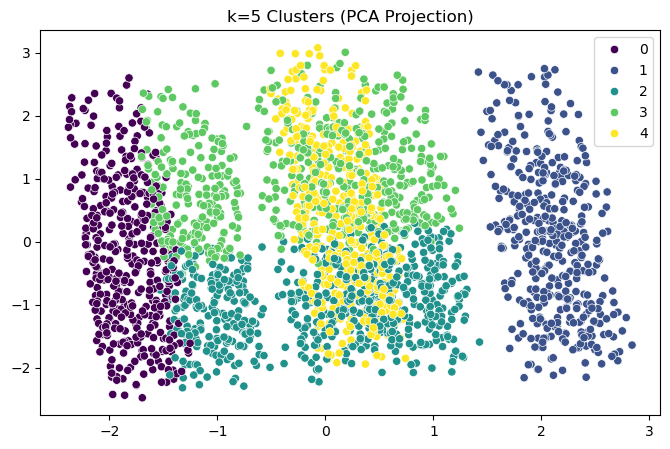

In [34]:
# Cluster Analysis based on this elbow graph

cluster_values = [3,4,5]
kmeans_models = {}

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for k in cluster_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    df[f'cluster_k{k}'] = labels  
    kmeans_models[k] = kmeans   

    #Metrics
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(X_scaled, labels)

    # Print Metrics
    print(f"For k = {k}:")
    print(f"Inertia (WCSS): {kmeans.inertia_:.4f}\n")
    print(f"Silhouette Score: {silhouette_avg:.4f}\n")  

    # Inverse-transform centers
    centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
    df_centers = pd.DataFrame(centers_original, columns=features)
    print("\nCluster Centers (Original Units):")
    print(df_centers.round(2))

    # Visualize
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="viridis")
    plt.title(f'k={k} Clusters (PCA Projection)')
    plt.show()



Profiling for k=3


'\nCluster Profiles (k=3):'

lithium_content       cobalt_content       nickel_content        \
                      mean   std           mean   std           mean   std   
cluster_k3                                                                   
0                    11.02  0.58           0.24  0.15           0.26  0.15   
1                     6.01  0.59          13.52  0.86           0.25  0.14   
2                     7.70  1.01           3.91  2.70           8.27  5.65   

           manganese_content       age_years       charge_cycles          \
                        mean   std      mean   std          mean     std   
cluster_k3                                                                 
0                       0.25  0.14      5.19  2.77        948.97  621.85   
1                       0.24  0.14      5.29  2.76        943.69  629.96   
2                       6.66  3.43      5.26  2.77        947.02  620.25   

           recycling_temp        recycling_time        size  
                     mean    std           mean   std        
cluster_k3                                                   
0                   65.39  14.15           5.05  1.75   425  
1                   65.36  13.78           4.99  1.71   412  
2                   65.18  14.62           4.96  1.74  1663

'\nBattery Type Distribution (k=3):'

cluster_k3        0    1    2
battery_type                 
Consumer_LCO      0  412    0
Consumer_NMC      0    0  431
EV_LFP          425    0    0
EV_NMC622         0    0  370
EV_NMC811         0    0  413
Industrial_LMO    0    0  449

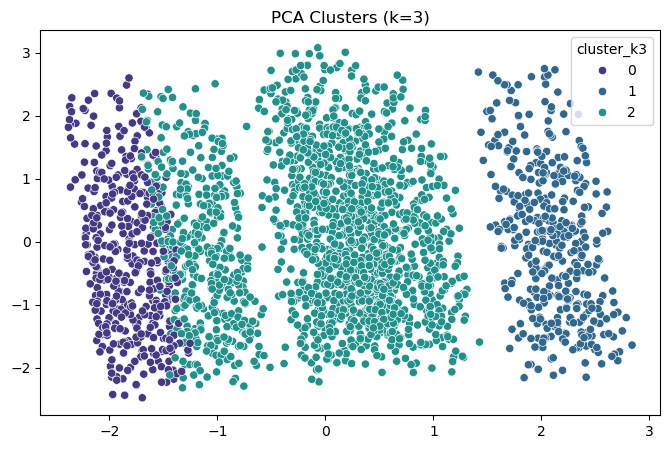

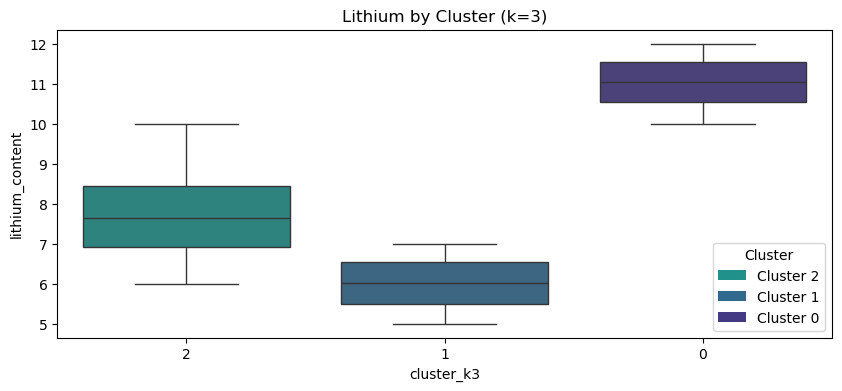


Profiling for k=4


'\nCluster Profiles (k=4):'

lithium_content       cobalt_content       nickel_content        \
                      mean   std           mean   std           mean   std   
cluster_k4                                                                   
0                     6.01  0.59          13.52  0.86           0.25  0.14   
1                    11.02  0.58           0.24  0.15           0.26  0.15   
2                     7.97  1.00           5.17  2.02          11.14  3.64   
3                     6.98  0.60           0.51  0.29           0.53  0.29   

           manganese_content       age_years       charge_cycles          \
                        mean   std      mean   std          mean     std   
cluster_k4                                                                 
0                       0.24  0.14      5.29  2.76        943.69  629.96   
1                       0.25  0.14      5.19  2.77        948.97  621.85   
2                       4.86  1.95      5.30  2.77        936.49  608.55   
3                      11.54  0.83      5.15  2.76        975.49  650.66   

           recycling_temp        recycling_time        size  
                     mean    std           mean   std        
cluster_k4                                                   
0                   65.36  13.78           4.99  1.71   412  
1                   65.39  14.15           5.05  1.75   425  
2                   65.22  14.69           4.93  1.74  1214  
3                   65.08  14.45           5.07  1.75   449

'\nBattery Type Distribution (k=4):'

cluster_k4        0    1    2    3
battery_type                      
Consumer_LCO    412    0    0    0
Consumer_NMC      0    0  431    0
EV_LFP            0  425    0    0
EV_NMC622         0    0  370    0
EV_NMC811         0    0  413    0
Industrial_LMO    0    0    0  449

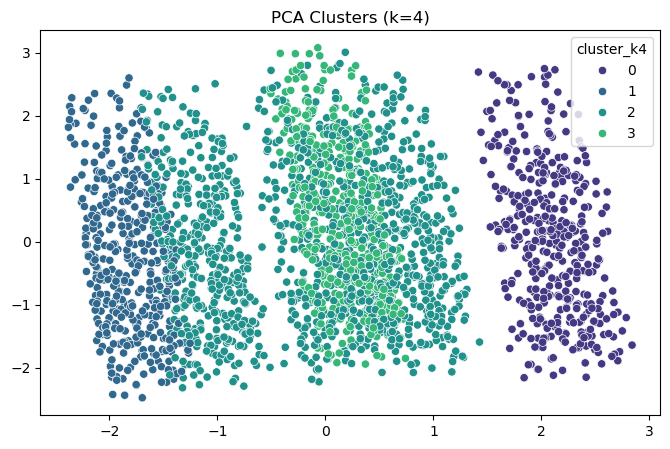

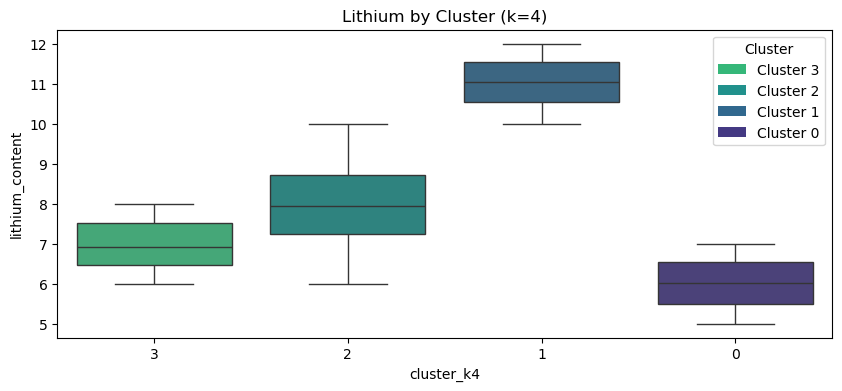


Profiling for k=5


'\nCluster Profiles (k=5):'

lithium_content       cobalt_content       nickel_content        \
                      mean   std           mean   std           mean   std   
cluster_k5                                                                   
0                    11.02  0.58           0.24  0.15           0.26  0.15   
1                     6.01  0.59          13.52  0.86           0.25  0.14   
2                     7.94  0.99           5.24  2.04          11.00  3.68   
3                     8.00  1.01           5.09  2.01          11.28  3.59   
4                     6.98  0.60           0.51  0.29           0.53  0.29   

           manganese_content       age_years       charge_cycles          \
                        mean   std      mean   std          mean     std   
cluster_k5                                                                 
0                       0.25  0.14      5.19  2.77        948.97  621.85   
1                       0.24  0.14      5.29  2.76        943.69  629.96   
2                       4.92  1.96      7.41  1.73        589.01  373.37   
3                       4.79  1.94      2.97  1.59       1318.83  587.88   
4                      11.54  0.83      5.15  2.76        975.49  650.66   

           recycling_temp        recycling_time       size  
                     mean    std           mean   std       
cluster_k5                                                  
0                   65.39  14.15           5.05  1.75  425  
1                   65.36  13.78           4.99  1.71  412  
2                   63.77  14.70           5.02  1.75  636  
3                   66.82  14.53           4.83  1.73  578  
4                   65.08  14.45           5.07  1.75  449

'\nBattery Type Distribution (k=5):'

cluster_k5        0    1    2    3    4
battery_type                           
Consumer_LCO      0  412    0    0    0
Consumer_NMC      0    0  239  192    0
EV_LFP          425    0    0    0    0
EV_NMC622         0    0  187  183    0
EV_NMC811         0    0  210  203    0
Industrial_LMO    0    0    0    0  449

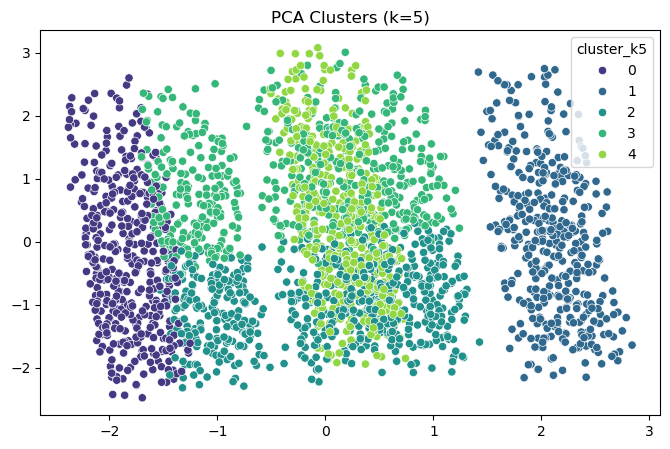

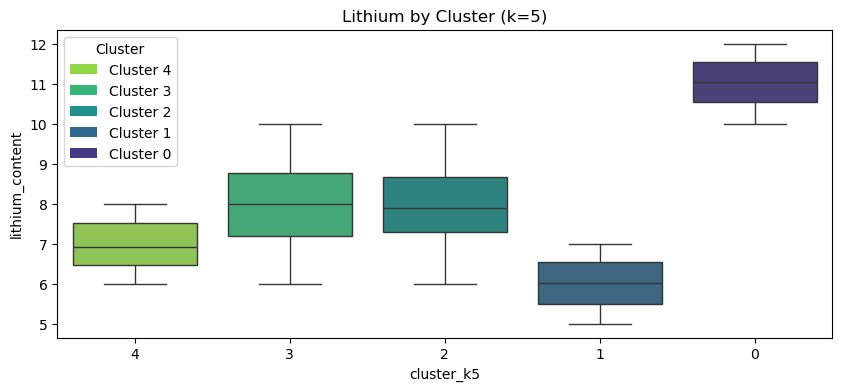

In [35]:
# Analyze clusters
for k in cluster_values:
    print(f"\n{'='*50}\nProfiling for k={k}\n{'='*50}")
    
    clusters = df[f'cluster_k{k}'] 
    hue_order = sorted(clusters.unique())
    palette = sns.color_palette("viridis", n_colors=5)
    
    # Assign clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    df[f'cluster_k{k}'] = kmeans.labels_  
    
    # --- Cluster Statistics ---
    # Mean + Std of features per cluster
    profile = df.groupby(f'cluster_k{k}')[features].agg(['mean', 'std']).round(2)
    # Add cluster sizes
    profile['size'] = df[f'cluster_k{k}'].value_counts().sort_index()
    display(f"\nCluster Profiles (k={k}):")
    display(profile)
    
    # --- Battery Type Distribution ---
    if 'battery_type' in df.columns:
        display(f"\nBattery Type Distribution (k={k}):")
        display(pd.crosstab(df['battery_type'], df[f'cluster_k{k}']))
    
    # --- Visualizations ---
    # PCA Plot
    plt.figure(figsize=(8, 5))
    scatter = sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], 
        hue=clusters, palette=palette[:k], 
        hue_order=hue_order, legend='full'
    )
    plt.title(f'PCA Clusters (k={k})')
    plt.show()
    
    # Box Plot (fixed)
    custom_order = sorted(df[f'cluster_k{k}'].unique(), reverse=True)  
    
    plt.figure(figsize=(10, 4))
    box = sns.boxplot(
        data=df, x=f'cluster_k{k}', y='lithium_content', 
        hue=clusters, 
        palette=palette[:k], 
        order=custom_order,
        hue_order=hue_order,
        legend=False,  
        dodge=False   
    )
    plt.title(f'Lithium by Cluster (k={k})')
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=palette[i], 
                       label=f'Cluster {i}') for i in custom_order]
    plt.legend(handles=legend_elements, title='Cluster')
    
    plt.show()

<Axes: >

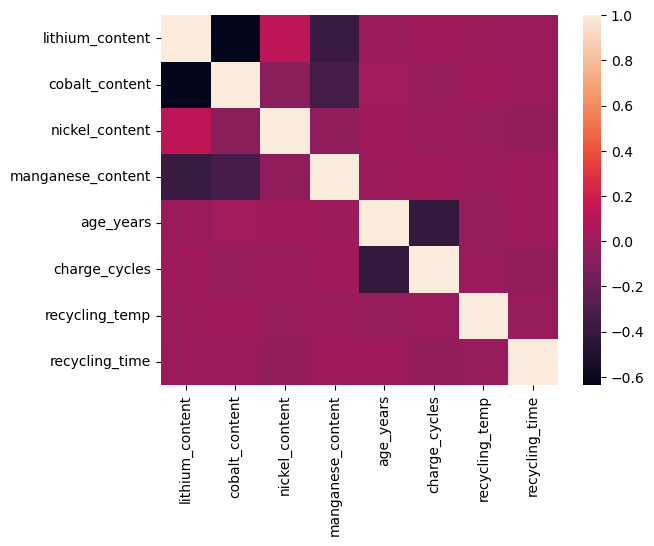

In [39]:
sns.heatmap(df[features].corr())

<Axes: xlabel='battery_type'>

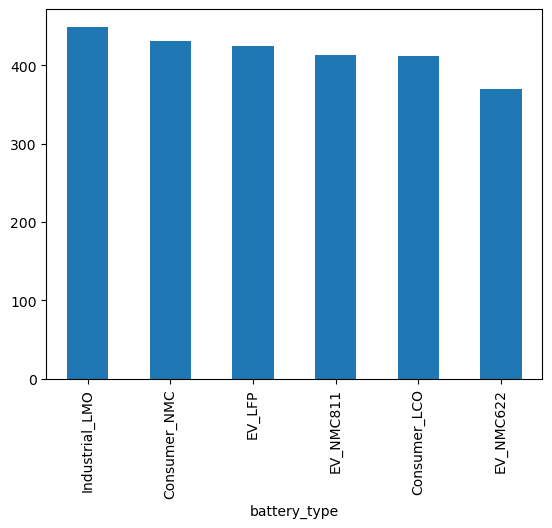

In [38]:
df['battery_type'].value_counts().plot(kind='bar')

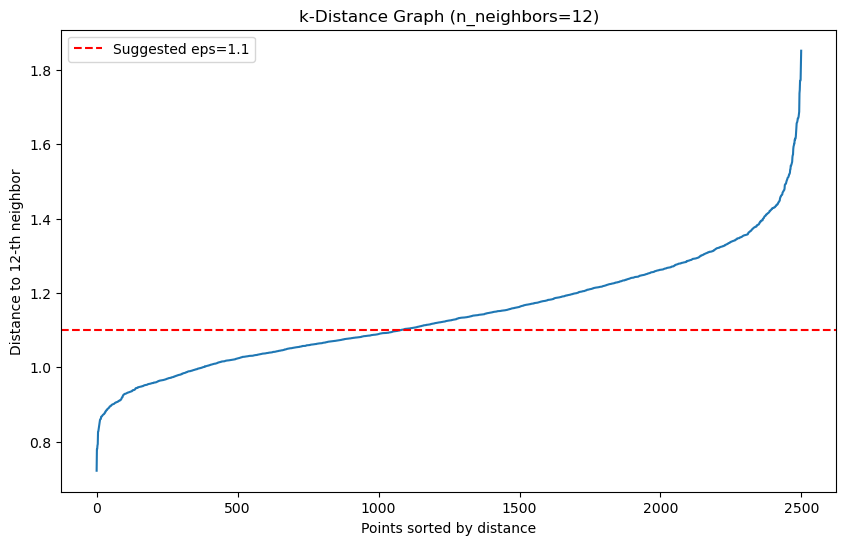


DBSCAN RESULTS:
• Clusters found: 6
• Noise points: 79 (3.2%)
• Cluster sizes:
  - Cluster -1: 79 batteries
  - Cluster 0: 427 batteries
  - Cluster 1: 397 batteries
  - Cluster 2: 403 batteries
  - Cluster 3: 1183 batteries
  - Cluster 4: 7 batteries
  - Cluster 5: 4 batteries


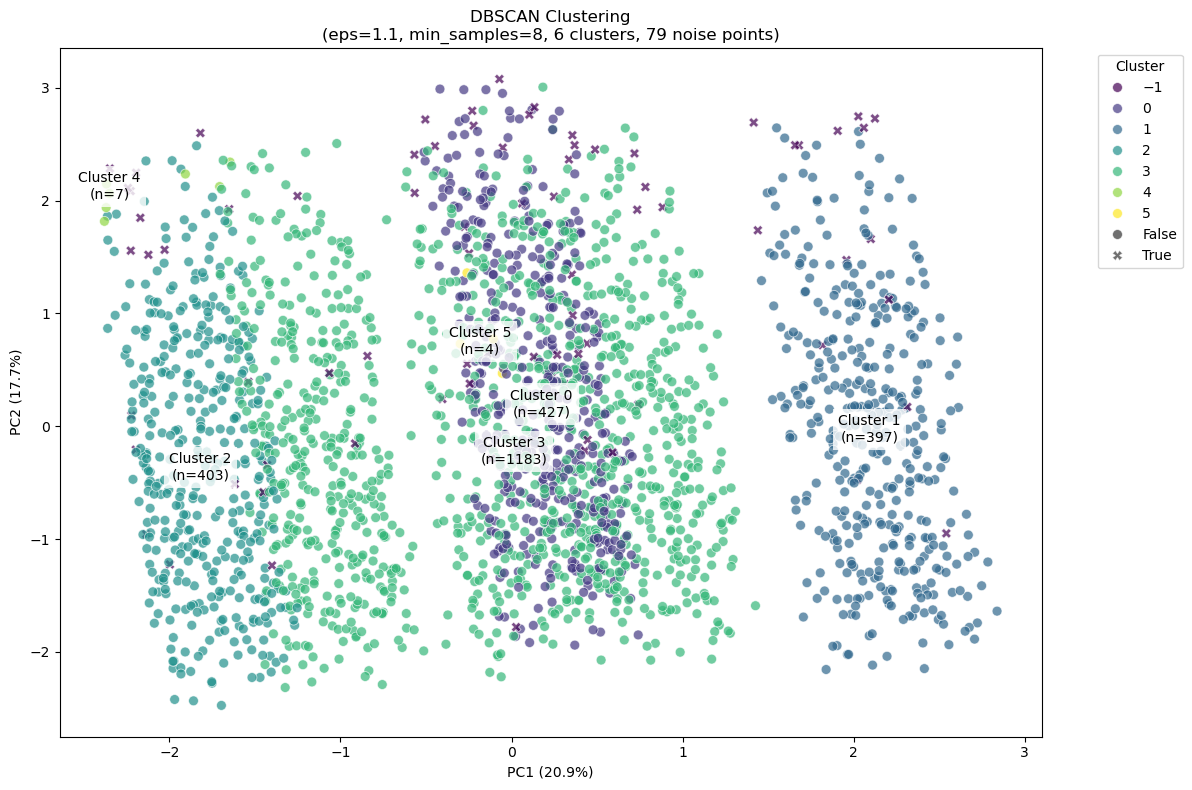

In [53]:
# Overlap ampng clusters indicates that K-means is not the appropriate algorithm to use.
# Here I try Density-Based Clustering using DBSCAN

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# =============================================
# STEP 1: Parameter Tuning with k-Distance Graph
# =============================================

# Optimal n_neighbors = 2 * n_features (or 0.5% of data)
n_neighbors = min(20, int(0.005 * len(X_scaled)))  # Cap at 20 for stability

nn = NearestNeighbors(n_neighbors=n_neighbors).fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.sort(distances[:, -1]))
plt.axhline(y=1.1, color='r', linestyle='--', label='Suggested eps=1.1')
plt.title(f'k-Distance Graph (n_neighbors={n_neighbors})')
plt.ylabel(f'Distance to {n_neighbors}-th neighbor')
plt.xlabel('Points sorted by distance')
plt.legend()
plt.show()

# =============================================
# STEP 2: DBSCAN Clustering with Optimized Params
# =============================================

# Recommended parameters for n=2500
eps = 1.1               # Slightly below the elbow (1.6 - buffer)
min_samples = 8         # Start with 8 (can adjust between 5-15)

db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
df['dbscan_cluster'] = db.labels_

# =============================================
# STEP 3: Results Analysis
# =============================================

# Calculate metrics
n_clusters = len(np.unique(db.labels_)) - 1  # Exclude noise
noise_count = np.sum(db.labels_ == -1)
cluster_counts = np.unique(db.labels_, return_counts=True)

print(f"""
DBSCAN RESULTS:
• Clusters found: {n_clusters}
• Noise points: {noise_count} ({noise_count/len(df):.1%})
• Cluster sizes:""")
for cluster, count in zip(*cluster_counts):
    print(f"  - Cluster {cluster}: {count} batteries")

# =============================================
# STEP 4: Enhanced Visualization
# =============================================

# Reduce to 2D for plotting (if not already done)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df['dbscan_cluster'],
    palette="viridis",
    style=df['dbscan_cluster'] == -1,
    markers={True: 'X', False: 'o'},
    s=50,
    alpha=0.7
)

# Add cluster annotations
for cluster in np.unique(db.labels_):
    if cluster != -1:
        plt.text(
            x=np.median(X_pca[db.labels_ == cluster, 0]),
            y=np.median(X_pca[db.labels_ == cluster, 1]),
            s=f'Cluster {cluster}\n(n={cluster_counts[1][cluster_counts[0] == cluster][0]})',
            fontsize=10, ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
        )

plt.title(
    f'DBSCAN Clustering\n(eps={eps}, min_samples={min_samples}, '
    f'{n_clusters} clusters, {noise_count} noise points)'
)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

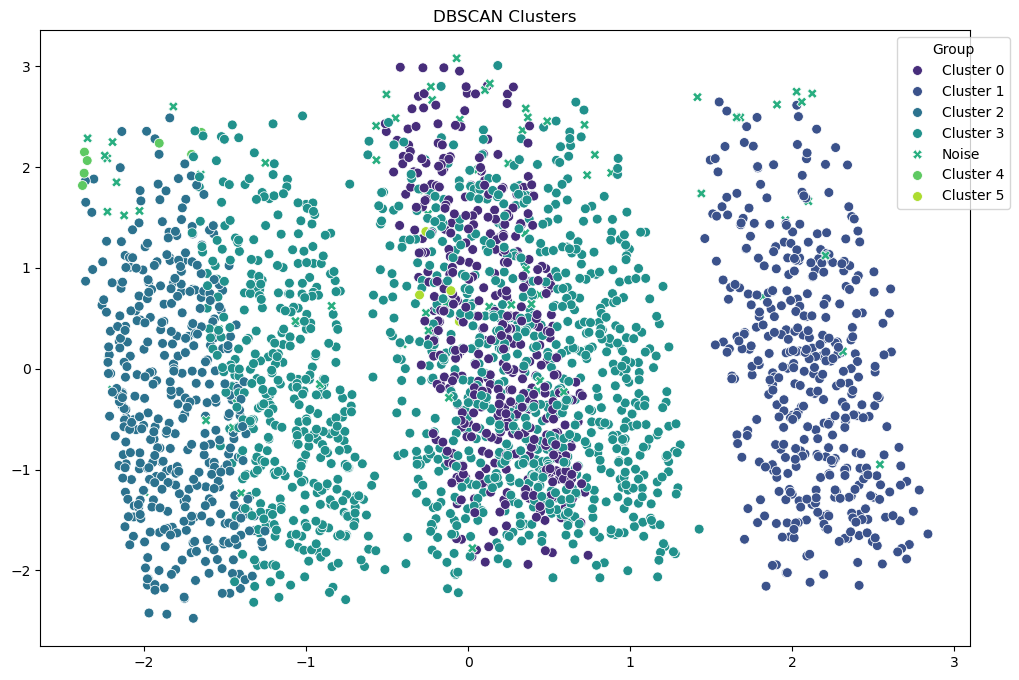

C:\Users\Acer\AppData\Local\Temp\ipykernel_13896\3707157705.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['dbscan_cluster']!=-1], x='dbscan_cluster', y='lithium_content',
C:\Users\Acer\AppData\Local\Temp\ipykernel_13896\3707157705.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['dbscan_cluster']!=-1], x='dbscan_cluster', y='profit_margin',


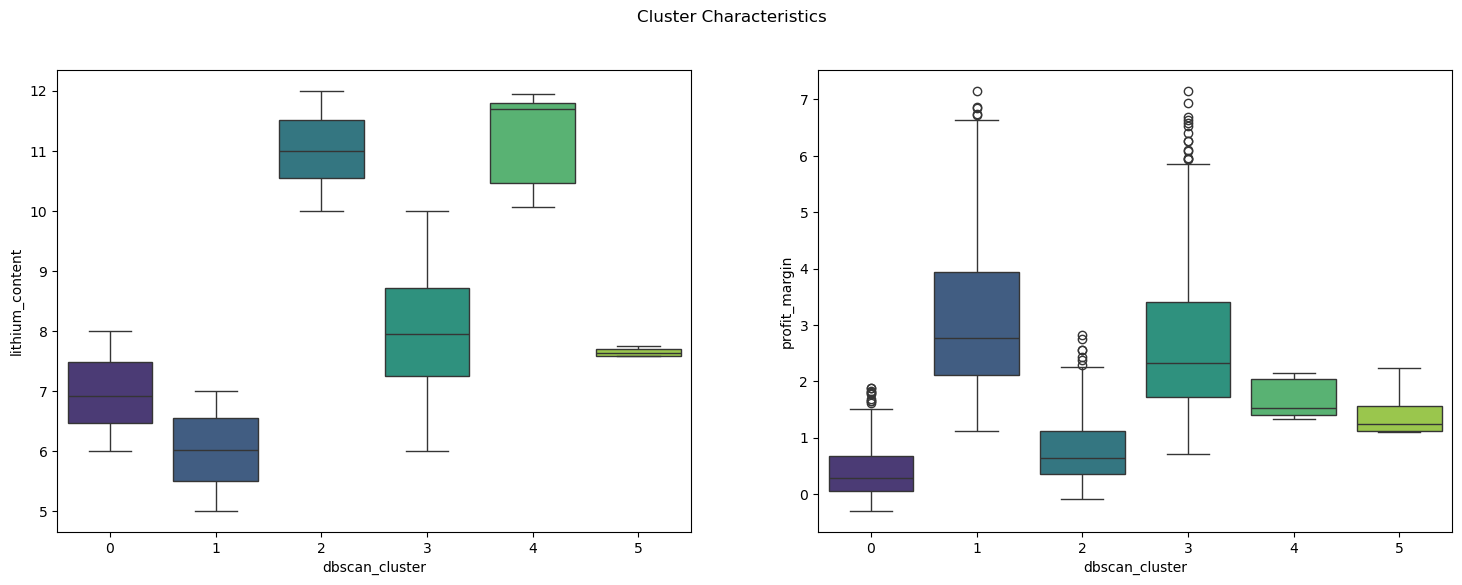

lithium_content          battery_type
                        median count        <lambda>
dbscan_cluster                                      
 4                   11.699736     7          EV_LFP
 2                   10.994886   403          EV_LFP
 3                    7.943182  1183    Consumer_NMC
 5                    7.635001     4  Industrial_LMO
-1                    7.532914    79  Industrial_LMO
 0                    6.906912   427  Industrial_LMO
 1                    6.012852   397    Consumer_LCO

In [55]:
# 1. Clean Visualization
plt.figure(figsize=(12,8))

# Create a new column for plotting
df['plot_group'] = df['dbscan_cluster'].apply(lambda x: 'Noise' if x == -1 else f'Cluster {x}')

sns.scatterplot(
    x=X_pca[:,0], 
    y=X_pca[:,1],
    hue=df['plot_group'],
    style=df['plot_group'],  # Style by the same groups
    palette="viridis",
    markers={'Noise': 'X', **{f'Cluster {i}': 'o' for i in range(6)}},
    s=50
)

plt.title('DBSCAN Clusters')
plt.legend(title='Group', bbox_to_anchor=(1.05, 1))
plt.show()

# 2. Boxplot Analysis
fig, axes = plt.subplots(1, 2, figsize=(18,6))
sns.boxplot(data=df[df['dbscan_cluster']!=-1], x='dbscan_cluster', y='lithium_content', 
            palette="viridis", ax=axes[0])
sns.boxplot(data=df[df['dbscan_cluster']!=-1], x='dbscan_cluster', y='profit_margin', 
            palette="viridis", ax=axes[1])
plt.suptitle('Cluster Characteristics')
plt.show()

# 3. Tabular Summary
display(df.groupby('dbscan_cluster').agg({
    'lithium_content': ['median', 'count'],
    'battery_type': lambda x: x.mode()[0]
}).sort_values(('lithium_content', 'median'), ascending=False))

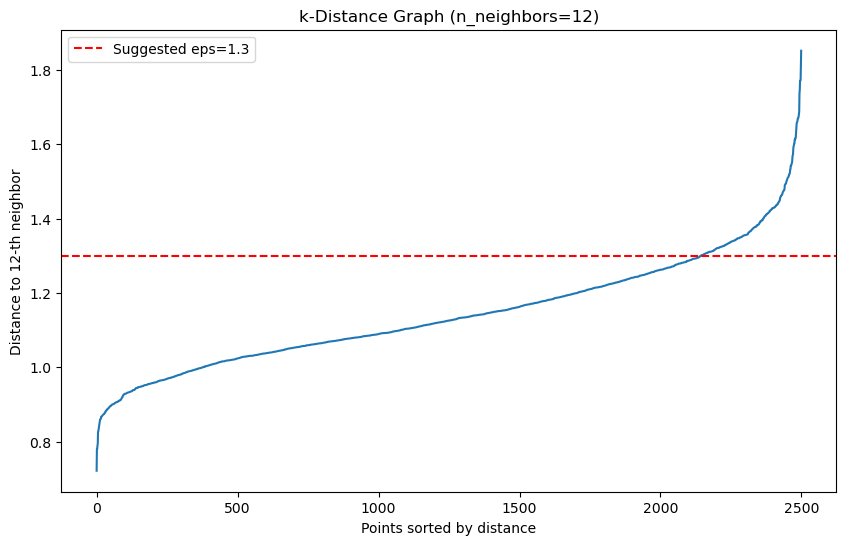

Cluster sizes: (array([-1,  0,  1,  2,  3], dtype=int64), array([   7,  448,  409,  423, 1213], dtype=int64))

DBSCAN RESULTS:
• Clusters found: 4
• Noise points: 7 (0.3%)
• Cluster sizes:
  - Cluster -1: 7 batteries
  - Cluster 0: 448 batteries
  - Cluster 1: 409 batteries
  - Cluster 2: 423 batteries
  - Cluster 3: 1213 batteries


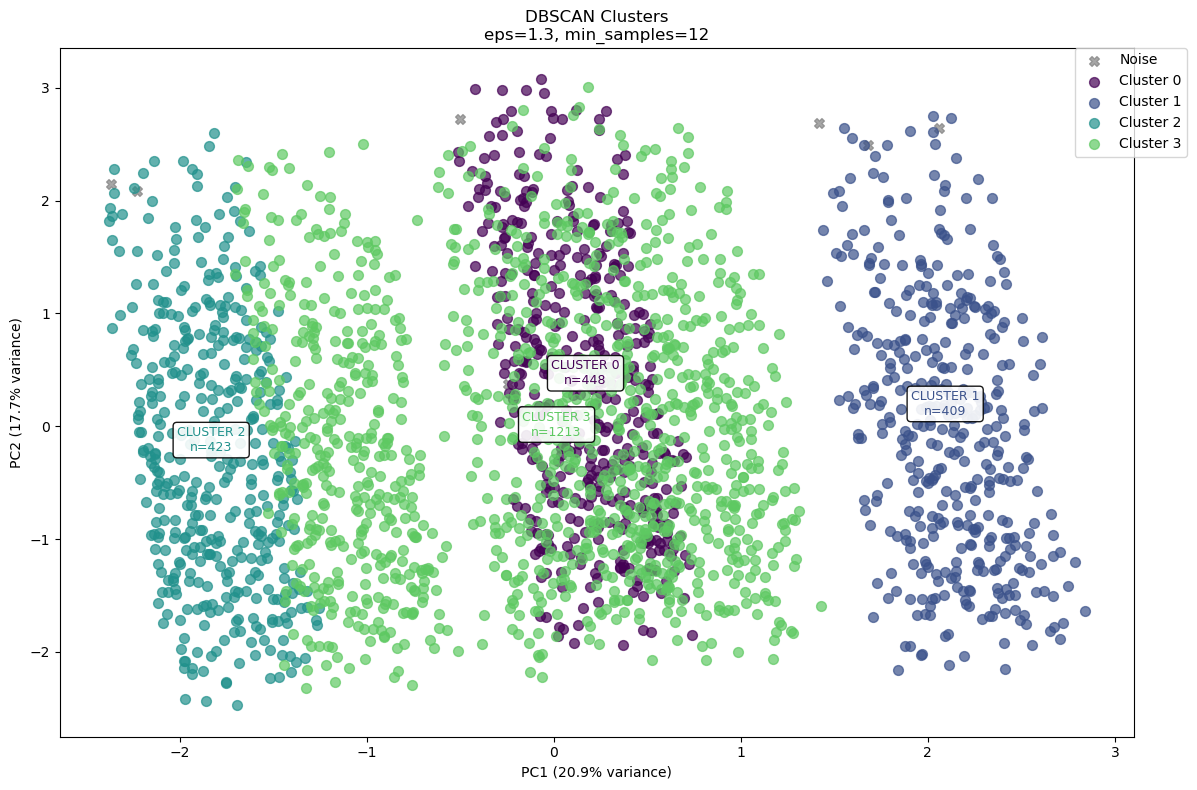

In [66]:

# =============================================
# STEP 1: Parameter Tuning with k-Distance Graph
# =============================================

# Optimal n_neighbors = 2 * n_features (or 0.5% of data)
n_neighbors = min(20, int(0.005 * len(X_scaled)))  # Cap at 20 for stability

nn = NearestNeighbors(n_neighbors=n_neighbors).fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.sort(distances[:, -1]))
plt.axhline(y=1.3, color='r', linestyle='--', label='Suggested eps=1.3')
plt.title(f'k-Distance Graph (n_neighbors={n_neighbors})')
plt.ylabel(f'Distance to {n_neighbors}-th neighbor')
plt.xlabel('Points sorted by distance')
plt.legend()
plt.show()

# =============================================
# STEP 2: DBSCAN Clustering with Optimized Params
# =============================================

# Recommended parameters for n=2500
eps = 1.3               # up from 1.1
min_samples = 12         # Up from 8 

db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
df['dbscan_cluster'] = db.labels_

print("Cluster sizes:", np.unique(db.labels_, return_counts=True))
# =============================================
# STEP 3: Results Analysis
# =============================================

# Calculate metrics
n_clusters = len(np.unique(db.labels_)) - 1  # Exclude noise
noise_count = np.sum(db.labels_ == -1)
cluster_counts = np.unique(db.labels_, return_counts=True)

print(f"""
DBSCAN RESULTS:
• Clusters found: {n_clusters}
• Noise points: {noise_count} ({noise_count/len(df):.1%})
• Cluster sizes:""")
for cluster, count in zip(*cluster_counts):
    print(f"  - Cluster {cluster}: {count} batteries")

# =============================================
# STEP 4: Enhanced Visualization (FIXED)
# =============================================

plt.figure(figsize=(12, 8))

# Create unified style mapping
style_map = {
    -1: {'color': 'gray', 'marker': 'X', 'label': 'Noise'},
    0: {'color': '#440154', 'marker': 'o', 'label': 'Cluster 0'},
    1: {'color': '#3b528b', 'marker': 'o', 'label': 'Cluster 1'}, 
    2: {'color': '#21918c', 'marker': 'o', 'label': 'Cluster 2'},
    3: {'color': '#5ec962', 'marker': 'o', 'label': 'Cluster 3'}
}

# Plot clusters and noise
for cluster in [-1, 0, 1, 2, 3]:
    mask = df['dbscan_cluster'] == cluster
    plt.scatter(
        x=X_pca[mask, 0],
        y=X_pca[mask, 1],
        c=style_map[cluster]['color'],
        marker=style_map[cluster]['marker'],
        label=style_map[cluster]['label'],
        s=50,
        alpha=0.7
    )

# Add cluster annotations with BOTH cluster number and size
for cluster in np.unique(db.labels_):
    if cluster != -1:
        count = cluster_counts[1][cluster_counts[0] == cluster][0]
        plt.annotate(
            f'CLUSTER {cluster}\nn={count}',
            xy=(np.median(X_pca[db.labels_ == cluster, 0]),
                np.median(X_pca[db.labels_ == cluster, 1])),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center',
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9),
            fontsize=9,
            color=style_map[cluster]['color']
        )

plt.title(f'DBSCAN Clusters\neps={eps}, min_samples={min_samples}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

In [67]:
# Verify cluster compositions
display(df.groupby('dbscan_cluster')[['lithium_content', 'cobalt_content', 'nickel_content']].median().sort_values('lithium_content'))

# Cross-tab with battery types
if 'battery_type' in df.columns:
    display(pd.crosstab(df['battery_type'], df['dbscan_cluster']))


lithium_content  cobalt_content  nickel_content
dbscan_cluster                                                 
 1                     6.011683       13.473533        0.260903
 0                     6.915433        0.525887        0.528245
-1                     7.770563        5.932536        0.319154
 3                     7.938983        6.013068       11.012046
 2                    11.027491        0.246931        0.252952

dbscan_cluster  -1    0    1    2    3
battery_type                          
Consumer_LCO     3    0  409    0    0
Consumer_NMC     0    0    0    0  431
EV_LFP           2    0    0  423    0
EV_NMC622        1    0    0    0  369
EV_NMC811        0    0    0    0  413
Industrial_LMO   1  448    0    0    0